## 8. EJERCICIO

Vamos a armar una pequeña competición en el curso.
El objetivo es armar una arquitectura de CNN que identifique el dataset MNIST.
Se van a usar capas de convolución, de activación y de pooling a elección. Cada alumno eligirá su modelo y los respectivos hiperparámetros, lo entrenará y presentará los siguientes resultados:

*   `test_acc` (del test final)
*   `n_parameter`
*   `n_layers` (conv + activacion + pooling = 1 capa)



El modelo se deberá ajustar a los siguientes parámetros:

*   train: 80%, validation: 10%, test: 10% (los datos serán dados así todos usan el mismo set para cada grupo. Están en el github el curso).
*   capa final de salida será una softmax de 10 elementos.
*   coss_function será `CrossEntropyLoss`.

El ganador de la competencia será aquel que consiga el mayor `score` empleando la siguietne fórmula:

$$ score = \frac{1}{log_{10}(n\_parameter)} *test\_acc*n\_layers$$

Deberan presentar su código colab funcionando y el score alcanzado (con los valores de cada variable que compone el score).

Es una competencia fairplay y con fines didácticos, esta formula del ```score``` fué inventada.... no usar como referencia para definir qué modelo utilizar.







#### Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Cargar base de datos

In [18]:
with open('./train.pkl', 'rb') as pkl:
    X_train = pickle.load(pkl)
with open('./train_label.pkl', 'rb') as pkl:
    y_train = pickle.load(pkl)

with open('./val.pkl', 'rb') as pkl:
    X_validation = pickle.load(pkl)
with open('./val_label.pkl', 'rb') as pkl:  
    y_validation = pickle.load(pkl)

with open('./test.pkl', 'rb') as pkl:
    X_test = pickle.load(pkl)
with open('./test_label.pkl', 'rb') as pkl:
    y_test = pickle.load(pkl)

print(type(X_train))
print(type(y_train))
print(type(X_validation))
print(type(y_validation))
print(type(X_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [19]:
print(X_train.shape)

(56000, 28, 28)


In [16]:
adaptacion = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [4]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
train = MyDataset(X_train, y_train)
validation = MyDataset(X_validation, y_validation)
test = MyDataset(X_test, y_test)

print(len(train))
print(len(validation))
print(len(test))

56000
7000
7000


In [22]:
dataloader = {
    'train': DataLoader(train, batch_size=64, shuffle=True, pin_memory=True),
    'validation': DataLoader(validation, batch_size=64, shuffle=True, pin_memory=True),
    'test': DataLoader(test, batch_size=64, shuffle=True, pin_memory=True)
}

2. Ver que la base de datos esté OK

In [7]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Feature batch shape: torch.Size([64, 28, 28])
Labels batch shape: torch.Size([64])
tamaño de 1 imagen:  torch.Size([28, 28])
tamaño 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


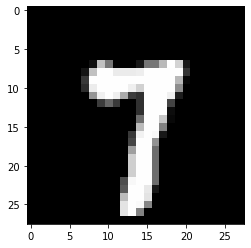

Label: 7


In [8]:
# Display image and label from dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = train_features[0].squeeze()
print('tamaño 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

3. Construyo mi CNN

In [9]:
def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [104]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None
    self.conv2 = block(64, 128)
    self.conv2_out = None
    self.conv3 = block(128, 128)
    self.conv3_out = None
    self.conv4 = block(128, 128)
    self.conv4_out = None
    self.conv5 = block(128,256)
    self.conv5_out = None
    self.fc = torch.nn.Linear(128*2, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = 28 #input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)
    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    y = self.conv5_out.view(self.conv5_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [105]:
model = CNN()

In [106]:
model.validar_dim()

Validacion de dimensiones
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 14, 14])
Tamaño salida conv2:  torch.Size([1, 128, 7, 7])
Tamaño salida conv3:  torch.Size([1, 128, 4, 4])
Tamaño salida conv4:  torch.Size([1, 128, 2, 2])
Tamaño salida conv5:  torch.Size([1, 256, 1, 1])
Tamaño imagen vectorizada:  torch.Size([1, 256])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [107]:
def fit(model, dataloader, device, epochs=150):
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        for batch in dataloader['train']:
            X, y = batch
            X = torch.unsqueeze(X, dim=1)
            X, y = X.to(device).float(), y.to(device)

            # Forward
            optimizer.zero_grad()
            y_hat = model(X)

            # Backprop
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in dataloader['test']:
                X, y = batch
                X = torch.unsqueeze(X, dim=1)
                X, y = X.to(device).float(), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [108]:
fit(model, dataloader, device, 6)

Epoch 1/6 loss 0.20388 val_loss 0.05855 acc 0.93839 val_acc 0.98144


KeyboardInterrupt: 

# score final